In [1]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

from mihm.data.process import multi_cat_to_one_hot, binary_to_one_hot, standardize_continuous_cols, convert_categorical_to_ordinal
from mihm.data.trainutils import train_test_split
from mihm.model.mihm import MIHM, IndexPredictionModel
from mihm.model.mihm_dataset import MIHMDataset
from mihm.model.modelutils import get_index_prediction_weights

In [2]:
read_cols = ["zPCPhenoAge_acc", "m_HeatIndex_7d", "age2016", "female", "racethn", "eduy", "ihs_wealthf2016", "pmono", "PNK_pct", 
            "PBcell_pct", "PCD8_Plus_pct", "PCD4_Plus_pct", "PNCD8_Plus_pct",
            "smoke2016", "drink2016", "bmi2016", "tractdis", "urban", "mar_cat2", "psyche2016", "stroke2016", "hibpe2016",
            "diabe2016", "hearte2016", "ltactx2016", "mdactx2016", "vgactx2016", "dep2016", "adl2016", 
            "living2016", "division"]

colname_dict = {
    "zPCPhenoAge_acc": "Pheno Age Accel.", 
    "m_HeatIndex_7d": "mean heat index over 7d", 
    "age2016": "age", 
    "female": "female", 
    "racethn": "race/ethnicity", 
    "eduy": "education (in years)", 
    "ihs_wealthf2016": "household wealth (ihs)", 
    "smoke2016": "smoking status", 
    "drink2016": "drinking status", 
    "bmi2016": "bmi", 
    "tractdis": "tract disadvantage", 
    "urban": "urbanicity", 
    "mar_cat2": "marital status", 
    "psyche2016": "psychiatric conditions", 
    "stroke2016": "stroke", 
    "hibpe2016": "hypertension",
    "diabe2016": "diabetes", 
    "hearte2016": "heart disease", 
    "ltactx2016": "light activity", 
    "mdactx2016": "moderate activity", 
    "vgactx2016": "vigorous activity", 
    "dep2016": "depressive symptoms", 
    "adl2016": "adl limitations", 
    "living2016": "living alone", 
    "division": "census division"
}

df = pd.read_stata('../HeatResilience.dta', columns=read_cols)
df.rename(columns=colname_dict, inplace=True)

In [3]:
categorical_cols = ['female', 'race/ethnicity', 'urbanicity', 'marital status', 'psychiatric conditions', 'stroke',
                    'hypertension', 'diabetes', 'heart disease', 'living alone', 'census division']
ordinal_cols = ['smoking status', 'drinking status', 'light activity', 'moderate activity', 'vigorous activity',]
continuous_cols = ['education (in years)', 'household wealth (ihs)', 'age', 'bmi', 
                   'tract disadvantage', 'depressive symptoms', 'adl limitations', 'mean heat index over 7d',
                    'pmono', "PNK_pct", "PBcell_pct", "PCD8_Plus_pct", "PCD4_Plus_pct", "PNCD8_Plus_pct",]
for c in categorical_cols:
    df[c] = df[c].astype("category")
binary_cats = [c for c in categorical_cols if df[c].nunique() <=2]
multi_cats = [c for c in categorical_cols if df[c].nunique() > 2]

In [4]:
# Preprocess df for model
df = binary_to_one_hot(df, binary_cats, dtype="category") # convert binary to one hot
df = multi_cat_to_one_hot(df, multi_cats, dtype="category") # convert multi cat to one hot
df = convert_categorical_to_ordinal(df, ordinal_cols) # convert ordinal to ordinal
df_norm, mean_std_dict = standardize_continuous_cols(df, continuous_cols) # standardize continuous cols
df_norm.dropna(inplace=True) # drop Nan rows

In [5]:
controlled_cols = [
    'mean heat index over 7d',
    "pmono",
    "PNK_pct",
    "PBcell_pct",
    "PCD8_Plus_pct",
    "PCD4_Plus_pct",
    "PNCD8_Plus_pct",
]
interaction_predictors = ['female', 'education (in years)', 'household wealth (ihs)', 
'smoking status', 'drinking status', 'bmi', 'tract disadvantage',
'marital status', 'psychiatric conditions', 'stroke', 'hypertension',
'diabetes', 'heart disease', 'light activity', 'moderate activity',
'vigorous activity', 'depressive symptoms', 'adl limitations',
'living alone', 'race/ethnicity_0. NHW', 'race/ethnicity_1. NHB',
'race/ethnicity_2. Hispanic', 'race/ethnicity_3. Others',
'urbanicity_1. urban', 'urbanicity_2. suurban (code 2)',
'urbanicity_3. ex-urban', 'census division_Northeast',
'census division_Midwest', 'census division_South', 'census division_West']

In [6]:
len(interaction_predictors)

30

### Train MLP

In [7]:
# interactor
heat_cont_np = df_norm['mean heat index over 7d'].to_numpy()
# controlled vars
controlled_vars_np = df_norm[controlled_cols].to_numpy()
# interaction input vars
interaction_vars_np = df_norm[interaction_predictors].to_numpy()
# dependent var (label)
pheno_epi_np = df_norm["Pheno Age Accel."].to_numpy()


In [9]:
num_elems, _ = controlled_vars_np.shape
print("number of data points: {}".format(num_elems))

number of data points: 3325


In [10]:
# split to train and test
train_idx, test_idx = train_test_split(num_elems, 0.7)
train_heat_cont = heat_cont_np[train_idx]
train_controlled_vars = controlled_vars_np[train_idx]
train_interaction_vars = interaction_vars_np[train_idx]
train_pheno_epi = pheno_epi_np[train_idx]

test_heat_cont = torch.from_numpy(heat_cont_np[test_idx].astype(np.float32))
test_controlled_vars = torch.from_numpy(controlled_vars_np[test_idx].astype(np.float32))
test_interaction_vars = torch.from_numpy(interaction_vars_np[test_idx].astype(np.float32))
test_pheno_epi = torch.from_numpy(pheno_epi_np[test_idx].astype(np.float32))

In [11]:
# create dataset
train_dataset = MIHMDataset(train_heat_cont, train_controlled_vars, train_interaction_vars, train_pheno_epi)
dataloader = DataLoader(train_dataset, batch_size=300, shuffle=True)

## Load model and train

In [12]:
interaction_var_size = interaction_vars_np.shape[1]
controlled_var_size = controlled_vars_np.shape[1]
hidden_layer_sizes = [50, 10, 1]
model = MIHM(interaction_var_size, controlled_var_size, hidden_layer_sizes, 
             include_interactor_bias=True, dropout=0.5)

In [13]:
torch.manual_seed(0)
mseLoss = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)
epochs = 500

In [14]:
model.eval()
with torch.no_grad():
    predicted_epi, predicted_index = model(test_interaction_vars, test_heat_cont, test_controlled_vars)
    loss_test = mseLoss(predicted_epi, test_pheno_epi)
    print("Testing Loss: {}".format(loss_test.item()))
early_stop_trigger_counter = 0
early_stop_tolerance = 0.3

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for batch_idx, sample in enumerate(dataloader):
        optimizer.zero_grad()
        # forward pass
        predicted_epi, predicted_index = model(sample["interaction_input_vars"], sample["interactor_var"], sample["controlled_vars"])
        label = torch.unsqueeze(sample["label"], 1)
        loss = mseLoss(predicted_epi, label)

        # backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # print average loss for epoch
    epoch_loss = running_loss / len(dataloader)

    # evaluation on test set
    model.eval()
    with torch.no_grad():
        predicted_epi, predicted_interaction = model(test_interaction_vars, test_heat_cont, test_controlled_vars)
        loss_test = mseLoss(predicted_epi, test_pheno_epi)
    print("Epoch {}/{} done!".format(epoch+1, epochs))
    print("Training Loss: {}".format(epoch_loss))
    print("Testing Loss: {}".format(loss_test.item()))
    # early stopping
    if loss_test.item() - epoch_loss > early_stop_tolerance*epoch_loss:
        early_stop_trigger_counter += 1
        if early_stop_trigger_counter > 5:
            print("Early stopping triggered!")
            break

/home/namj/miniconda3/envs/hrs/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([998])) that is different to the input size (torch.Size([998, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Testing Loss: 15.30655288696289
Epoch 1/500 done!
Training Loss: 155.70190048217773
Testing Loss: 13.968945503234863
Epoch 2/500 done!
Training Loss: 122.7722978591919
Testing Loss: 12.802277565002441
Epoch 3/500 done!
Training Loss: 109.48868942260742
Testing Loss: 11.690460205078125
Epoch 4/500 done!
Training Loss: 104.02502632141113
Testing Loss: 10.67949104309082


Epoch 5/500 done!
Training Loss: 97.07172775268555
Testing Loss: 9.68865966796875
Epoch 6/500 done!
Training Loss: 94.39626598358154
Testing Loss: 8.767742156982422
Epoch 7/500 done!
Training Loss: 82.54326152801514
Testing Loss: 7.915709972381592
Epoch 8/500 done!
Training Loss: 75.92424201965332
Testing Loss: 7.170045375823975
Epoch 9/500 done!
Training Loss: 69.73507356643677
Testing Loss: 6.536733150482178
Epoch 10/500 done!
Training Loss: 65.85108518600464
Testing Loss: 5.990691661834717
Epoch 11/500 done!
Training Loss: 62.88373851776123
Testing Loss: 5.4894022941589355
Epoch 12/500 done!
Training Loss: 53.937880992889404
Testing Loss: 5.062647342681885
Epoch 13/500 done!
Training Loss: 50.26009225845337
Testing Loss: 4.737376689910889
Epoch 14/500 done!
Training Loss: 49.88501787185669
Testing Loss: 4.449724197387695
Epoch 15/500 done!
Training Loss: 47.87893319129944
Testing Loss: 4.182371139526367
Epoch 16/500 done!
Training Loss: 41.91950082778931
Testing Loss: 3.951778888702

In [15]:
all_interaction_vars_tensor = torch.from_numpy(interaction_vars_np.astype(np.float32))
model.eval()
predicted_index = model.get_resilience_index(all_interaction_vars_tensor)
all_resilience_index = predicted_index.detach().numpy()

In [16]:
all_resilience_index = (all_resilience_index - all_resilience_index.mean())/all_resilience_index.std()

(array([  3.,   8., 124., 513., 476., 373., 310., 276., 283., 225., 212.,
        140., 118.,  70.,  60.,  33.,  39.,  21.,  13.,   9.,   5.,   6.,
          0.,   3.,   1.,   1.,   2.,   0.,   0.,   1.]),
 array([-1.97040439, -1.70208335, -1.43376219, -1.16544116, -0.89712   ,
        -0.6287989 , -0.36047783, -0.09215674,  0.17616436,  0.44448546,
         0.71280652,  0.98112762,  1.24944878,  1.51776981,  1.78609097,
         2.05441189,  2.32273316,  2.5910542 ,  2.85937524,  3.12769628,
         3.39601755,  3.66433859,  3.93265963,  4.20098066,  4.4693017 ,
         4.73762274,  5.00594425,  5.27426529,  5.54258633,  5.81090736,
         6.0792284 ]),
 <BarContainer object of 30 artists>)

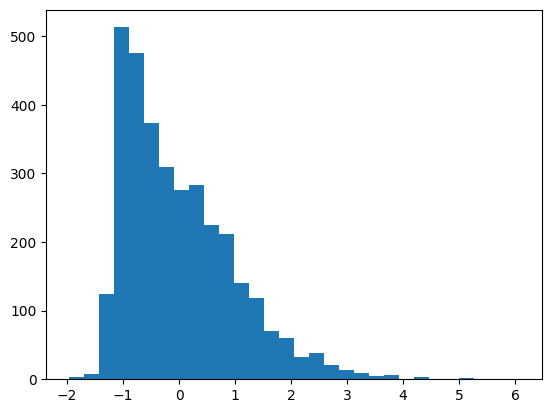

In [17]:
plt.hist(all_resilience_index, bins=30)

In [18]:
torch.save(model.state_dict(), "../checkpoints/Feb14_heat_model_nopca.pth")

### Shapley Analysis

In [19]:
import shap
import matplotlib.pyplot as plt
shap.initjs()

In [20]:
model_name = "Feb4_heat_model_pca_v4"

In [21]:
interaction_var_size = interaction_vars_np.shape[1]
controlled_var_size = controlled_vars_np.shape[1]
hidden_layer_sizes = [50, 10, 1]
model = IndexPredictionModel(interaction_var_size, hidden_layer_sizes, 
                             svd=True, svd_matrix=V.cuda(), k_dim=10)

In [22]:
state_dict = torch.load('../checkpoints/{}.pth'.format(model_name))
state_dict_index = get_index_prediction_weights(state_dict)
model.load_state_dict(state_dict_index)
model.cuda().eval()

IndexPredictionModel(
  (layers): ModuleList(
    (0): Linear(in_features=10, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [23]:
interaction_vars_torch = torch.from_numpy(interaction_vars_np.astype('float32')).cuda()
explainer = shap.DeepExplainer(model, interaction_vars_torch)

In [24]:
shap_values = explainer.shap_values(interaction_vars_torch[:1000], check_additivity=False)

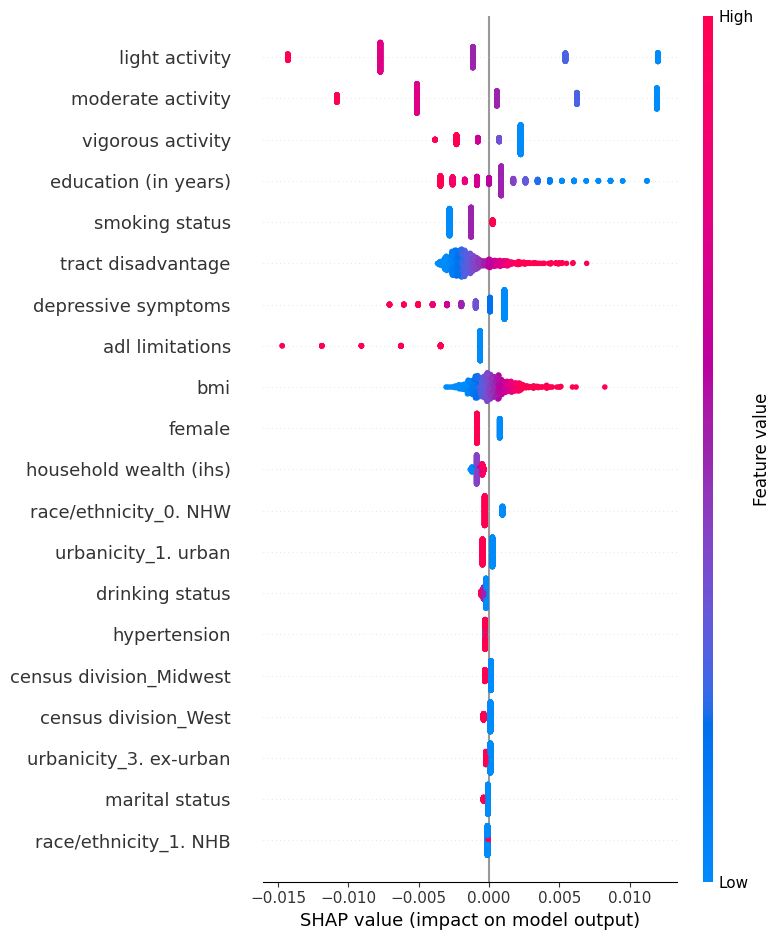

In [25]:
shap.summary_plot(shap_values[:, :], interaction_vars_torch[:1000, :].detach().cpu().numpy(), feature_names=interaction_predictors, show=False)
plt.savefig("../figures/{}.png".format(model_name), dpi=300, bbox_inches="tight")